In [78]:
import numpy as np
import pandas as pd
import scipy as sp
import plotly.express as px
import networkx as nx
import degroot as dg
from tqdm import tqdm
import plotly.graph_objects as go
from joblib import Parallel, delayed

In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [194]:
# Parameters
dims = 8
erdos_reni_p = 0.2
n_initial_conditions_attempts = 100
max_edge_value = 1
init_belief = np.random.uniform(0.2, 0.8, size=dims)
correct_belief = 0.95
niter_degroot = 2
niter_search = 10_000
symmetric = False

In [195]:
def generate_initial_conditions(n: int, p: float, n_attempts: int):
    initial_conditions = []
    for i in range(n_attempts):
        m = nx.adjacency_matrix(nx.erdos_renyi_graph(n=n, p=p)).todense()
        if np.min(np.sum(m, axis=1)) == 0 or np.max(np.sum(m, axis=1)) == n-1:
            continue
            
        m = np.random.randint(1, max_edge_value + 1, size=(n, n)) * m
        initial_conditions.append(m)
    
    unique_initial_conditions = np.unique([s.flatten() for s in initial_conditions], axis=0)
    unique_initial_conditions = [s.reshape(dims, dims) for s in unique_initial_conditions]
    print('Number of unique initial conditions:', len(unique_initial_conditions))
    return unique_initial_conditions

In [196]:
def generate_initial_conditions_fixed_graph(n: int, p: float, n_attempts: int):
    m_base = nx.adjacency_matrix(nx.erdos_renyi_graph(n=n, p=p)).todense()
    while np.min(np.sum(m_base, axis=0)) == 0 or np.max(np.sum(m_base, axis=1)) == n-1:
        m_base = nx.adjacency_matrix(nx.erdos_renyi_graph(n=n, p=p)).todense()
        
    initial_conditions = dg.get_rewiring_sample(m0=m_base, n_rewiring_attempts=n_attempts)
    print('Number of unique initial conditions:', len(initial_conditions))
    return initial_conditions

In [197]:
init_cond = generate_initial_conditions_fixed_graph(n=dims, p=erdos_reni_p, n_attempts=n_initial_conditions_attempts)

Number of unique initial conditions: 100


In [198]:
error = solution_quality_histogram = dg.compute_histogram_of_solution_quality(m0=init_cond[0], initial_belief=init_belief, correct_belief=correct_belief, niter_degroot=niter_degroot, n_samples=100_000)
hist, bins = np.histogram(error['estimate'], bins=100)
px.scatter(x=bins[1:], y=hist)

100%|██████████| 100000/100000 [00:01<00:00, 65793.50it/s]


In [199]:
results = Parallel(n_jobs=-1)(delayed(dg.myopic_search)(m0=x, niter_search=niter_search, max_edge_value=max_edge_value, initial_belief=init_belief, correct_belief=correct_belief, niter_degroot=niter_degroot)  for x in tqdm(init_cond))

100%|██████████| 100/100 [00:00<00:00, 156.43it/s]


In [200]:
meta_data = pd.DataFrame([{'final_error': r.error, 'initial_error': r.initial_error, 'converged': r.converged, 'iterations': r.iterations, 'num': i} for i, r in enumerate(results)])
px.scatter(meta_data, x='initial_error', y='final_error', color='converged', hover_data=['num'], render_mode='svg')

In [182]:
px.histogram(meta_data, x='iterations', color='converged')

In [201]:
flat_solutions = np.array([r.m.flatten() for r in results])
dist = sp.spatial.distance.pdist(flat_solutions, metric='hamming')
hist, bins = np.histogram(dist, bins=dims)
px.scatter(x=bins[1:], y=hist)

In [202]:
influence = []
for r in results:
    sol = r.m / np.sum(r.m, axis=1)[:, None]
    influence_ = np.sum(sol, axis=0)
    influence.append(influence_)
    
influence_mean = np.mean(influence, axis=0)
influence_std = np.std(influence, axis=0)
influence_ci = 1.96 * influence_std / np.sqrt(len(influence))
px.scatter(x=np.abs(init_belief-correct_belief), y=influence_mean, error_y=influence_std, labels={'x': 'Initial error', 'y': 'Influence'})

In [203]:
belief_evol = []
did_not_converge = 0
total = 0
for i, r in enumerate(results):
    for t in r.trajectory:
        total += 1
        belief = r.trajectory[t]['final_belief']
        if np.max(sp.spatial.distance.pdist(belief.reshape(-1,1), metric='euclidean')) > 1e-5:
            did_not_converge += 1

        belief_evol.append({'belief': np.mean(belief), 'result': f'Res{i}', 'iteration': t})

print('Did not converge share:', did_not_converge / total)
belief_evol = pd.DataFrame(belief_evol).sort_values('belief', ascending=False)
fig = px.scatter(belief_evol, x='iteration', y='belief', color='result', render_mode='svg')
fig.add_trace(go.Scatter(x=[0, belief_evol['iteration'].max()], y=[correct_belief, correct_belief], mode='lines', name='Correct belief'))
fig.show()

Did not converge share: 1.0


In [204]:
len(np.unique(flat_solutions, axis=0))

74

0.034929498217191254 True


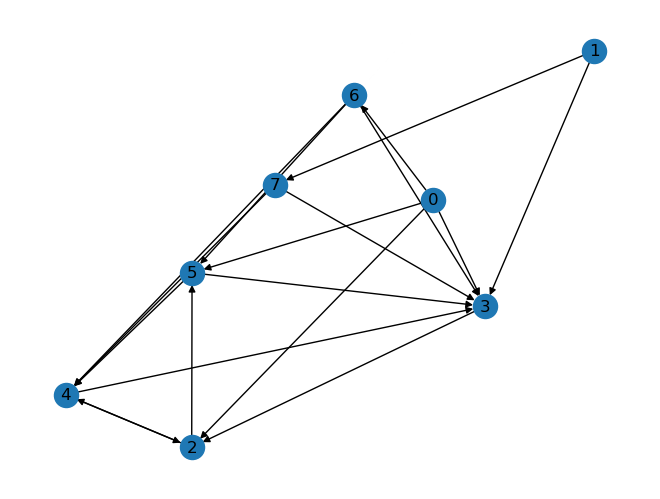

In [112]:
r = results[26]
g = nx.from_numpy_array(r.m, create_using=nx.DiGraph)
print(r.error, r.converged)
pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=True)

In [113]:
pd.DataFrame({'initial_belief': init_belief, 'correct_belief': correct_belief, 'diff': np.abs(init_belief-correct_belief), 'node': np.arange(dims)}).sort_values('diff')

,initial_belief,correct_belief,diff,node
7,0.832436,0.8,0.032436,7
2,0.869184,0.8,0.069184,2
4,0.934003,0.8,0.134003,4
5,0.438381,0.8,0.361619,5
3,0.347528,0.8,0.452472,3
0,0.312584,0.8,0.487416,0
6,0.198108,0.8,0.601892,6
1,0.119453,0.8,0.680547,1


In [114]:
n1 = init_cond[0]